In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load the combined parquet data

file_path = '/Users/maushariff/Downloads/Local_Disk_E/Byrav/Internet2_Data/Atla/combined_internet_traffic_data.parquet'
df = pd.read_parquet(file_path)


In [9]:
# Check the column names in the DataFrame
print(df.columns)


Index(['export_sysid', 't_last', 'proto', 'src4_addr', 'dst4_addr', 'src_port',
       'dst_port', 'src_tos', 'dst_tos', 'in_packets', 'input_snmp',
       'output_snmp', 'src_as', 'dst_as', 'src_mask', 'dst_mask',
       'ip4_next_hop', 'ip4_router', 'src6_addr', 'dst6_addr', 'ip6_next_hop'],
      dtype='object')


In [10]:
# Convert 't_last' to datetime and set it as the index
df['t_last'] = pd.to_datetime(df['t_last'])  # Convert to datetime
df.set_index('t_last', inplace=True)  # Set 't_last' as the index

# Resample to hourly traffic volume
hourly_data = df['in_packets'].resample('H').sum().reset_index()

# Rename columns for Prophet compatibility (ds for date, y for values)
hourly_data.columns = ['ds', 'y']

# Check the first few rows to confirm
print(hourly_data.head())


/var/folders/l_/89dqsbtj1ys_lqvc8b_phr300000gq/T/ipykernel_45106/4161484110.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_data = df['in_packets'].resample('H').sum().reset_index()


                   ds          y
0 2021-10-07 23:00:00     390000
1 2021-10-08 00:00:00  585470000
2 2021-10-08 01:00:00  559475000
3 2021-10-08 02:00:00  547740000
4 2021-10-08 03:00:00  613875000


In [12]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(hourly_data[['y']])

# Define a function to create sequences for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define sequence length (how many previous hours to use to predict the next hour)
sequence_length = 24  # Using 24 previous hours to predict the next hour

# Create sequences
X, y = create_sequences(scaled_data, sequence_length)

# Reshape X for LSTM: [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets (80% train, 20% test)
train_size = int(0.8 * X.shape[0])
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f'Training samples: {X_train.shape}, Testing samples: {X_test.shape}')


Training samples: (596, 24, 1), Testing samples: (149, 24, 1)


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(sequence_length, 1)))  # First LSTM layer
model.add(Dropout(0.2))  # Dropout for regularization
model.add(LSTM(100, return_sequences=False))  # Second LSTM layer
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


/Users/maushariff/Downloads/Local_Disk_E/Byrav/Fall24 996 Reserach with Internet2 Data/VsCodeWorkspace/myenv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch 1/10


/Users/maushariff/Downloads/Local_Disk_E/Byrav/Fall24 996 Reserach with Internet2 Data/VsCodeWorkspace/myenv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0243 - val_loss: 0.0090
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0191 - val_loss: 0.0084
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0163 - val_loss: 0.0066
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0105 - val_loss: 0.0059
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0136 - val_loss: 0.0055
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0097 - val_loss: 0.0044
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0076 - val_loss: 0.0054
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0075 - val_loss: 0.0035
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0083 - val_loss: 0.0033
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0062 - val_loss: 0.0032


In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Make predictions
predicted_train = model.predict(X_train)
predicted_test = model.predict(X_test)

# Inverse scale to get original values
predicted_train_rescaled = scaler.inverse_transform(predicted_train)
predicted_test_rescaled = scaler.inverse_transform(predicted_test)
y_train_rescaled = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MAE and RMSE
train_mae = mean_absolute_error(y_train_rescaled, predicted_train_rescaled)
test_mae = mean_absolute_error(y_test_rescaled, predicted_test_rescaled)
train_rmse = np.sqrt(mean_squared_error(y_train_rescaled, predicted_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_rescaled, predicted_test_rescaled))

print(f'Train MAE: {train_mae}, Train RMSE: {train_rmse}')
print(f'Test MAE: {test_mae}, Test RMSE: {test_rmse}')


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Train MAE: 177880818.33892617, Train RMSE: 258621961.5944942
Test MAE: 144142342.55033556, Test RMSE: 188914630.28445712


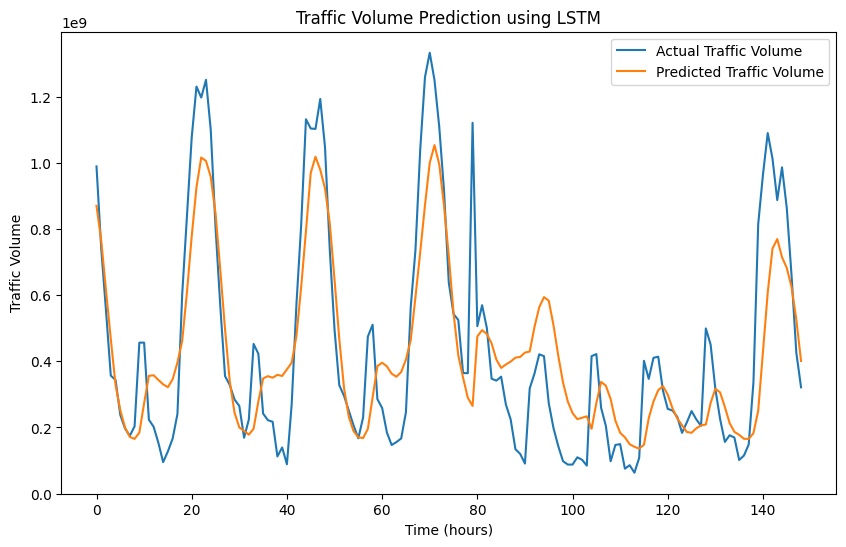

In [17]:
import matplotlib.pyplot as plt

# Plot the predictions vs actual values
plt.figure(figsize=(10, 6))

plt.plot(y_test_rescaled, label='Actual Traffic Volume')
plt.plot(predicted_test_rescaled, label='Predicted Traffic Volume')
plt.title('Traffic Volume Prediction using LSTM')
plt.xlabel('Time (hours)')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()
